## RELAX INC - Data Science Challenge

# Predict Future User Adoption

Defining  an  "adopted  user" as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven day  period, identify  which  factors  predict  future  user
adoption.

- Import packages

In [1]:
from scipy.stats import norm
from scipy.stats import t
import numpy as np
import pandas as pd
from numpy.random import seed
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from scipy.stats import chi2_contingency
from pingouin import pairwise_ttests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

/Users/gabriellewald/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## 1. Visualize users data

In [2]:
# read csv file
users = pd.read_csv('data/takehome_users.csv')
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# checking for missing data
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [4]:
# update object_id to user_id
users = users.rename(columns={"object_id": "user_id"})

In [5]:
users['user_id'].nunique()

12000

- There are 12,000 users and 10 columns

## 2. Visualize engagement data

In [6]:
# read csv
engage_df = pd.read_csv('data/takehome_user_engagement.csv')
engage_df

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [7]:
engage_df['user_id'].nunique()

8823

- There are 207,917 logins and 8823 unique users. In order to facilitate analysis, time_stamp is transformed to datetime and set as the index.

In [8]:
# transform time_stamp to datetime 
engage_df['time_stamp'] = pd.to_datetime(engage_df['time_stamp'])

# make time_stamp index
engage_df = engage_df.set_index('time_stamp')

In [9]:
# check for missing data and if time_stamp is datetime 
engage_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8 MB


## 3. Number of adopted users

In [10]:
# Add label to engage_df
def label_adopted(user_id):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    user_df = engage_df.loc[engage_df['user_id'] == user_id] #select out rows of this user
    user_df = user_df.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    
    for i in range(len(user_df) - 2): #loop over active days till the second to last day
        if user_df.index[i + 2] - user_df.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            return 1
    return 0

In [11]:
# Call function create column adopted_user in users
users['adopted_user'] = users['user_id'].apply(label_adopted)

In [12]:
print('The platform has', users['adopted_user'].sum(), "active users, that's about",  
      (users['adopted_user'].sum()/len(users['adopted_user']))*100,'%', 'of total registered users.')

The platform has 1656 active users, that's about 13.8 % of total registered users.


In [13]:
# See users dataframe
users.head(10)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1


## 4. Exploratory Data Analysis

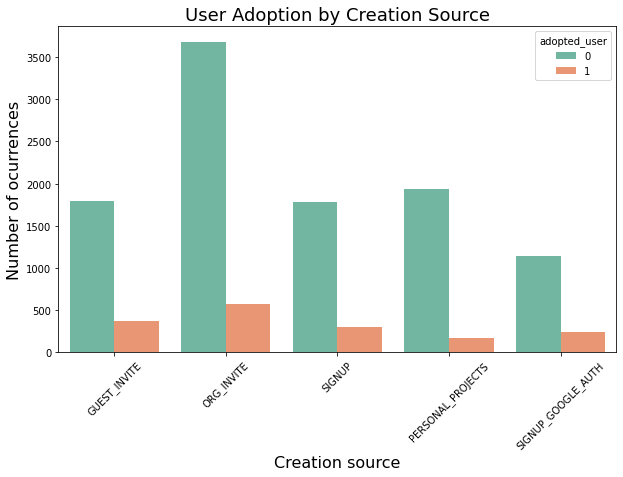

In [14]:
# Plot creation source and adopted user
plt.figure(figsize=(10,6))
_ = sns.countplot(x='creation_source', data=users, hue='adopted_user', palette='Set2')
_ = plt.xticks(rotation=45)
_ = plt.title('User Adoption by Creation Source', fontsize=18)
_ = plt.xlabel('Creation source', fontsize=16)
_ = plt.ylabel('Number of ocurrences', fontsize=16)


### 4. a. Is there an association between creation source and adoption rate?

In [15]:
# Crosstab creation source and adopted user to test independence
crosstab = pd.crosstab(users['creation_source'], users['adopted_user']).T
crosstab

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
adopted_user,,,,,
0,1794,3680,1939,1785,1146
1,369,574,172,302,239


In [16]:
# Apply chi2 to test if there's any association between different creation source and adoption
g, p, dof, expctd = chi2_contingency(crosstab)

print("p-value of Chi-square test for creation source vs. adopted/notadopted users =", p)

p-value of Chi-square test for creation source vs. adopted/notadopted users = 7.884346873316259e-19


- There is an association between the creation source and number of adopted users. However, here we are not looking at the difference between sources of creation and number of students who adopted the platform. We are also considering the number of users that did not adopt the platform. 
- Next, let's look only at adopted users vs creation source!

In [17]:
# Interested in the difference between creation source for adopted users only
adopted = crosstab.drop([0])
adopted

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
adopted_user,,,,,
1,369,574,172,302,239


In [18]:
# Apply chi2 to test if there's any association between different creation source and adoption
g, p, dof, expctd = chi2_contingency(adopted)

print("p-value of Chi-square test for creation source vs. adopted user =", p)

p-value of Chi-square test for creation source vs. adopted user = 1.0


- There's no significant difference between the number of adopted users for each creation source.

### 4. b. Users adoption rate by creation source

In [19]:
# Adoption rate
users.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

In [ ]:
# Plot proportion of adopted users
plt.figure(figsize=(10,6))
sns.barplot(x='adopted_user', y='creation_source', data=users, 
            estimator=lambda x: sum(x==1)*100.0/len(x),  palette='husl')
_ = plt.title('User Adoption Rate by Creation Source', fontsize=18)
_ = plt.xlabel('Adopted users %', fontsize=16)
_ = plt.ylabel('Creation source', fontsize=16)

- The plot helps us visualize the difference between adoption rate per each one of the creation sources.
- We can use pairwise t-test to verify if there is one kind of sign-up (adoption source) that's statistically better than the others.

### 4. c. Pairwise t-test: is there a sigificant difference between the creation sources?

In [ ]:
# Creat df with prporption to apply pairwise t-test
df1 = pd.DataFrame({"creation_source":["GUEST_INVITE", "ORG_INVITE ", 
                                       "PERSONAL_PROJECTS", "SIGNUP", "SIGNUP_GOOGLE_AUTH"],
                    "adoption_rate":[0.170596, 0.134932, 0.081478, 0.144705, 0.172563]})
df1

In [ ]:
# # Apply pairwise t-test
# pairwise_results = pairwise_ttests(dv='adoption_rate', between = ['creation_source'], tail='two-sided', data=df1)
# pairwise_results = pairwise_results[['A', 'B', 'p-unc']]
# pairwise_results = round(pairwise_results.sort_values(by=['p-unc'], ascending=False), 5)
# pairwise_results

## 5. Predictive Modeling

In [ ]:
# Create dummy variable for creation source
creation_source = pd.get_dummies(users['creation_source'], drop_first=True)

# Concatenate dummies to users df
model_data = pd.concat([users, creation_source], axis=1).drop('creation_source', axis=1)

# Create target and features variables
y = model_data['adopted_user']
X = model_data.drop(['adopted_user', 'email', 'creation_time', 'user_id', 'name', 'invited_by_user_id', 'last_session_creation_time'], axis=1)

In [ ]:
# Features
X

In [ ]:
# train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

### 5. a. Random Forest Classifier

In [ ]:
# Use random forest model
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(Xtrain, ytrain)

print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

In [ ]:
# Apply best model
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=10
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

In [ ]:
# Feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

------